# Detrended quantile mapping vs quantile delta mapping

This notebook is for comparing detrended quantile mapping (and some variants thereof) and quantile delta mapping. 

In [226]:
# config cell
from pathlib import Path
import cftime
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from pyproj import Proj
from xclim import units, sdba, indices
from dask.distributed import Client

# for reloading the baeda module which is actively developing
import baeda
from importlib import reload

reload(baeda)

cutoff_time = cftime.DatetimeNoLeap(2015, 1, 1, 0, 0, 0, 0, 0)

zarr_dir = Path("/beegfs/CMIP6/kmredilla/zarr_bias_adjust_inputs/zarr")
era5_dir = Path("/beegfs/CMIP6/kmredilla/era5_3338_zarr/zarr")

In [2]:
client = Client()

## Setup

### Test locations

We will perform an analysis on a handful of test locations across Alaska, seen here:

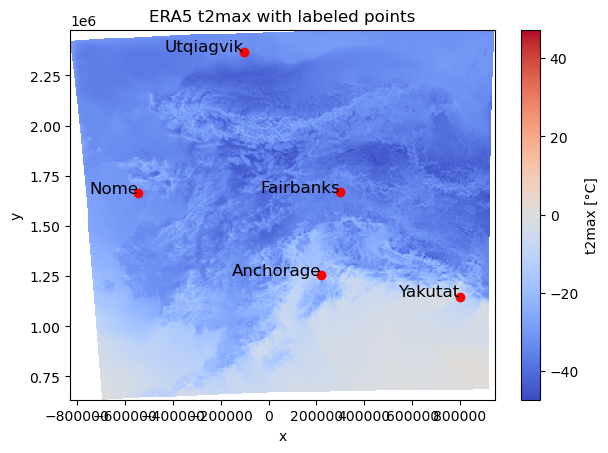

In [3]:
era5_store = era5_dir.joinpath("t2max_era5.zarr")
with xr.open_zarr(era5_store) as ds:

    # Define the WKT projection for the ERA5 data
    wkt_projection = ds.spatial_ref.attrs["crs_wkt"]

    proj = Proj(wkt_projection)

    # Convert lat, lon to the projection system
    projected_coords = {}
    for point, latlon in baeda.coords.items():
        x, y = proj(latlon["lon"], latlon["lat"])
        projected_coords[point] = {"x": x, "y": y}

    time_slice = ds.isel(time=0)

    units.convert_units_to(time_slice.t2max, "degC").plot(cmap="coolwarm")

for point, coord in projected_coords.items():
    plt.plot(coord["x"], coord["y"], "ro")
    plt.text(coord["x"], coord["y"], point, fontsize=12, ha="right")

plt.tight_layout()
plt.title("ERA5 t2max with labeled points")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Methods

### Extraction and adjustment

We will extract and perform bias adjustment for the test locations and for each of the DQM and QDM methods specified in the `baeda` module. 
The `baeda.run_bias_adjustment_and_package_data` does this and wraps the results up into a dataframe. 

### Summarization

Once we have the results, we can create some summaries to aid in evaluation of the methods. For each variable, we will compute a set of indicators (i.e. indices) across all datasets (including ERA5 and unadjusted GCM historical and future). These indicators will be used in the following ways:

1. To compare distributions between adjusted GCM historical and the ERA5 reference data
2. To evaluate the ability of methods to preserve the changes in these indicators

## Maximum daily temperature (`tasmax`)

Perform bias adjustment and do some data wrangling / packaging:

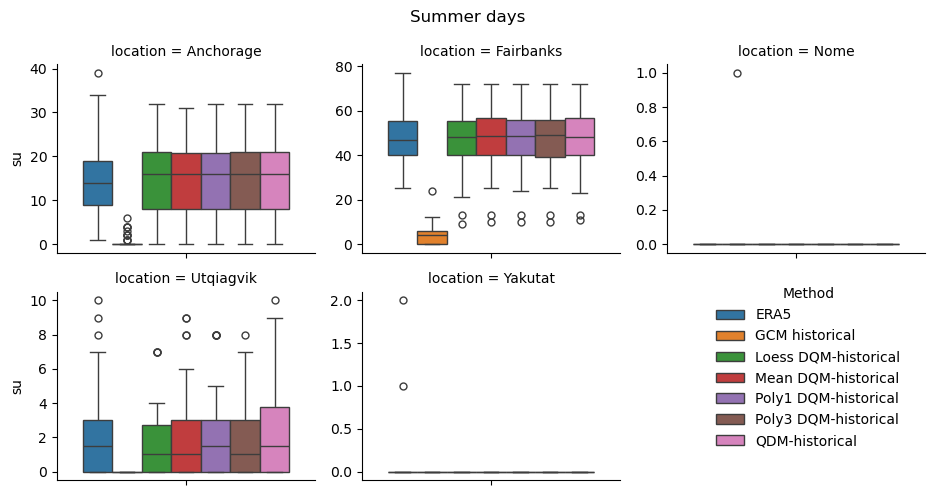

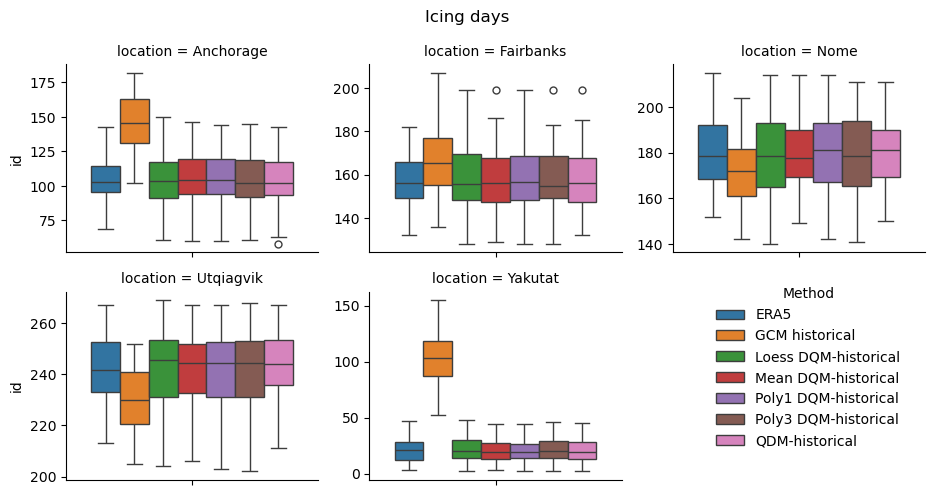

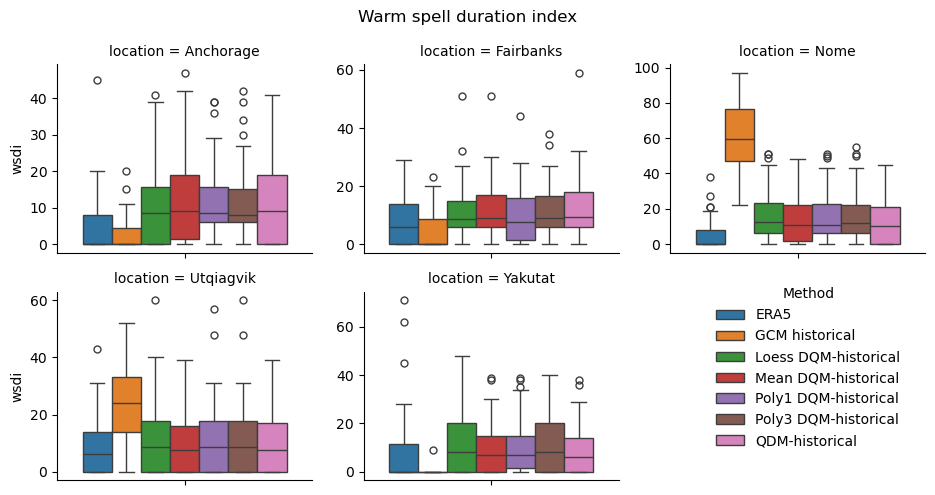

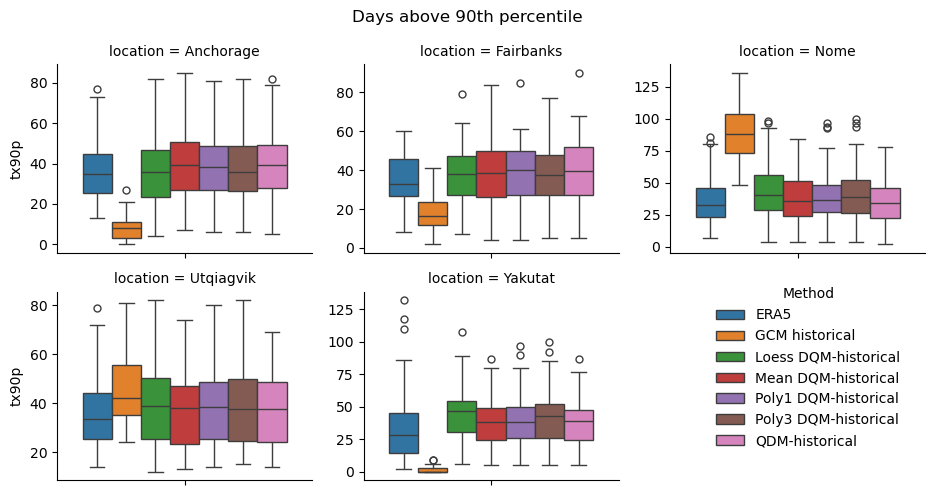

In [235]:
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "tasmax"

# if this function fails with some "failed on block" type error, try running again
adj_df = baeda.run_bias_adjustment_and_package_data(
    zarr_dir, model, scenario, var_id, projected_coords
)
# Break the data into historical and future periods
adj_historical_df = adj_df[adj_df["time"] < cutoff_time]
adj_future_df = adj_df[adj_df["time"] >= cutoff_time]

historical_indicators = baeda.run_indicators(adj_historical_df)

for indicator in historical_indicators.data_vars:
    baeda.indicator_boxplot_by_method_location(historical_indicators, indicator)

## Daily precipitation (`pr`)

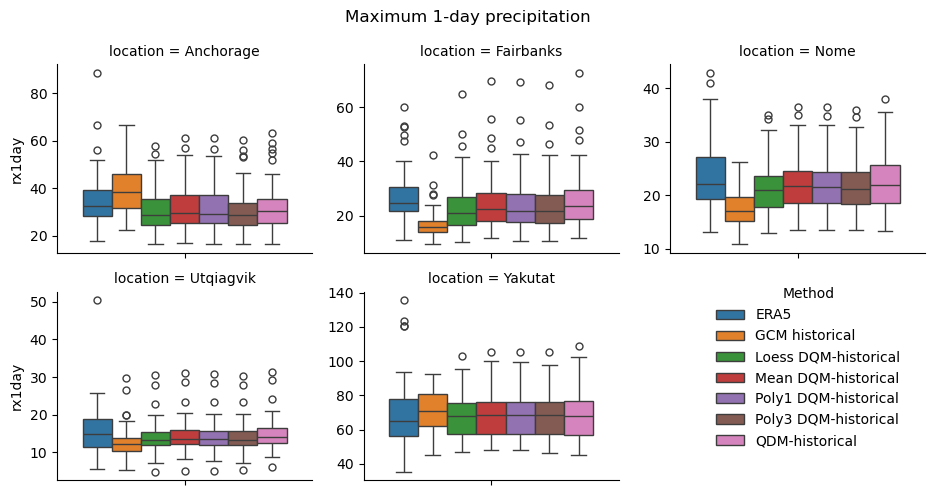

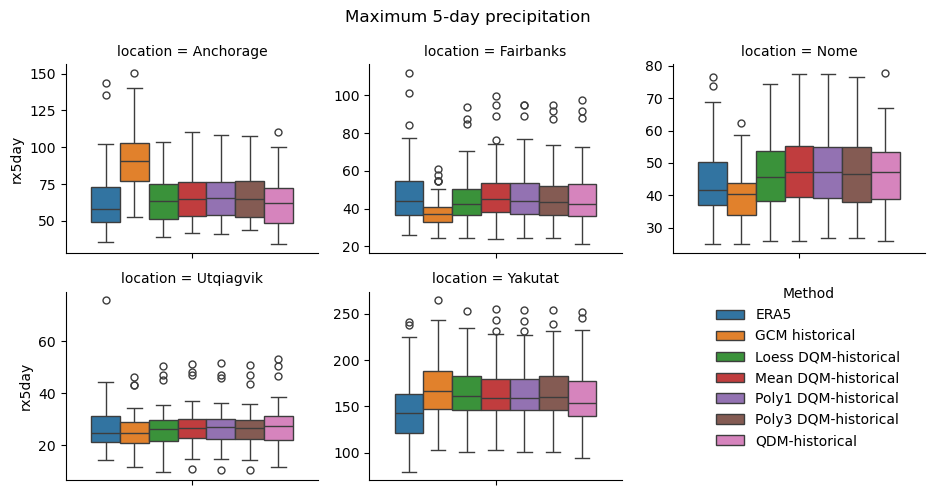

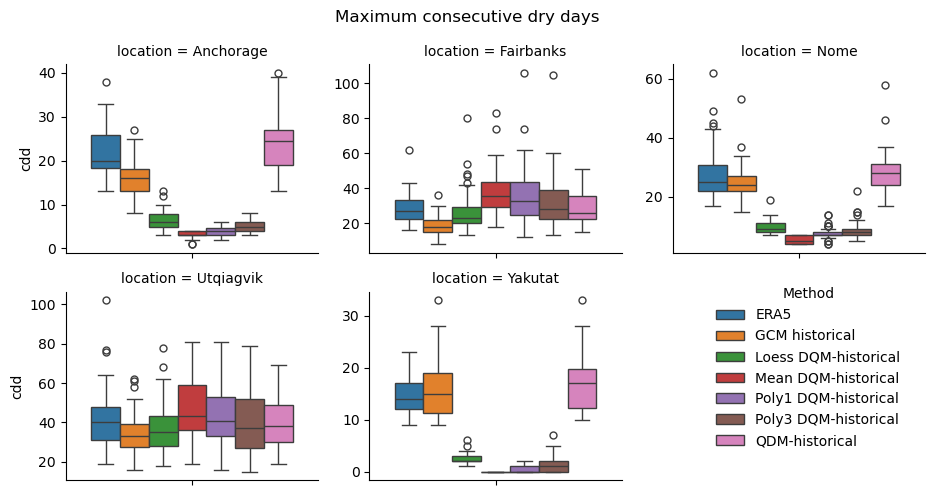

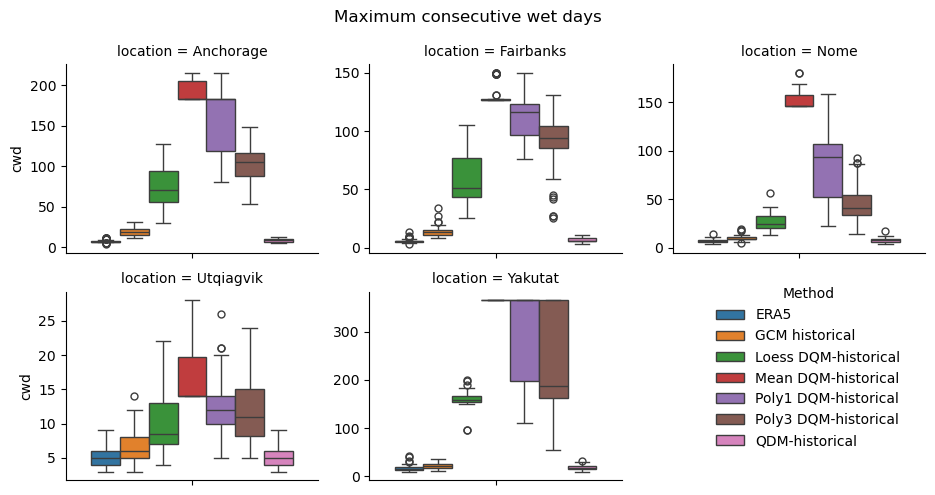

In [234]:
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"

# if this function fails with some "failed on block" type error, try running again
adj_df = baeda.run_bias_adjustment_and_package_data(
    zarr_dir, model, scenario, var_id, projected_coords
)
# Break the data into historical and future periods
adj_historical_df = adj_df[adj_df["time"] < cutoff_time]
adj_future_df = adj_df[adj_df["time"] >= cutoff_time]

historical_indicators = baeda.run_indicators(adj_historical_df)

for indicator in historical_indicators.data_vars:
    baeda.indicator_boxplot_by_method_location(historical_indicators, indicator)